# 0D Filtrations And Applications
## Topology Lecture 9/6/2018
## Chris Tralie

In [1]:
%matplotlib notebook
import numpy as np
from scipy import ndimage
from ripser import ripser, plot_dgms
import matplotlib.pyplot as plt
from scipy import sparse
import time
import PIL
from MergeTree import *
from mpl_toolkits.mplot3d import Axes3D
import sys 
sys.path.append("pyhks")
from HKS import *

import ipywidgets as widgets
from IPython.display import display


## Lower Star Images


First, we define a function to perform the lower star filtration

In [2]:
def lower_star_image(D):
    """
    Construct a lower star filtration on an image
    Parameters
    ----------
    D: ndarray (M, N)
        An array of image data
    Returns
    -------
    I: ndarray (K, 2)
        A 0D persistence diagram corresponding to the sublevelset filtration
    """
    idxs = np.arange(D.shape[0]*D.shape[1])
    idxs = np.reshape(idxs, D.shape)
    I = idxs.flatten()
    J = idxs.flatten()
    V = D.flatten()
    # Do 8 spatial neighbors
    tidxs = np.nan*np.ones((D.shape[0]+2, D.shape[1]+2), dtype=np.int64)
    tidxs[1:-1, 1:-1] = idxs
    tD = np.nan*np.ones_like(tidxs)
    tD[1:-1, 1:-1] = D
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            if di == 0 and dj == 0:
                continue
            thisJ = np.roll(tidxs, di, axis=0)
            thisJ = np.roll(thisJ, dj, axis=1)
            thisD = np.roll(tD, di, axis=0)
            thisD = np.roll(thisD, dj, axis=1)
            thisD = np.maximum(thisD, tD)
            # Deal with boundaries
            thisI = tidxs[np.isnan(thisD)==0]
            thisJ = thisJ[np.isnan(thisD)==0]
            thisD = thisD[np.isnan(thisD)==0]
            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))
    sparseDM = sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))
    return ripser(sparseDM, distance_matrix=True, maxdim=0)['dgms'][0]

## Hair Example


/home/ctralie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in maximum


<IPython.core.display.Javascript object>


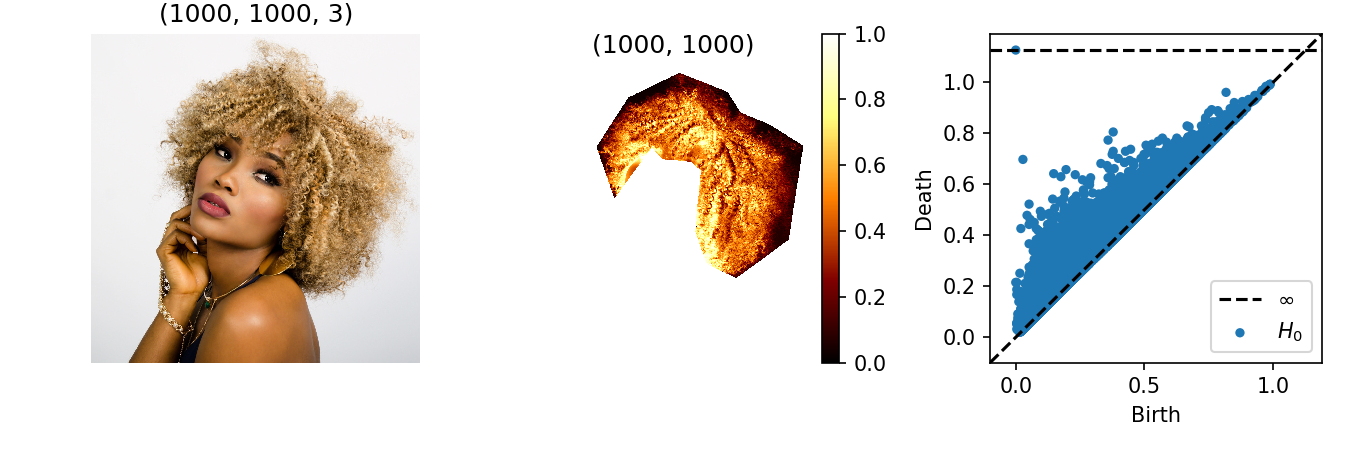

In [9]:
## NOTE: Need to scale by mask area


import glob

directoryName = '.' # Replace this with whatever directory

for f in glob.glob("%s/*.jpg"%directoryName):
    hair_original = plt.imread(f)
    mask = plt.imread("%s_mask.png"%f[0:-4])
    hair_grey = np.asarray(PIL.Image.fromarray(hair_original).convert('L'))
    hair_grey = hair_grey*mask


    # Smoothing (helps with noise, but could destroy structure at fine scales)
    #hair_grey = ndimage.uniform_filter(hair_grey, size=10)


    # Switching from sublevelset to superlevelset
    hair_grey = -hair_grey


    # Normalize to the range [0, 1] so that full contrast goes from 0 to 1
    hair_grey = hair_grey - np.min(hair_grey)
    hair_grey = hair_grey/np.max(hair_grey)


    # Do lower star filtration after adding a little bit of noise
    # The noise is a hack to help find representatives for the classes
    I = lower_star_image(hair_grey)
    I = I[I[:, 1]-I[:, 0] > 0.001, :] # Filter out low persistence values
    
    
    ## TODO: Make two persistence images: one for sublevelset and one for superlevelset
    ## https://github.com/scikit-tda/persim/blob/master/notebooks/Persistence%20Images.ipynb
    ## https://github.com/scikit-tda/persim/blob/master/notebooks/Classification%20with%20persistence%20images.ipynb
    
    
    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.title(hair_original.shape)
    plt.imshow(hair_original)
    plt.axis('off')
    plt.subplot(132)
    plt.title(hair_grey.shape)
    plt.imshow(hair_grey, cmap='afmhot')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(133)
    plot_dgms(I)
    plt.tight_layout()
    plt.show()